# Head Boost for ICL

In [27]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

init_notebook_mode(connected=True)

Device: cuda


### Model

In [31]:
model_name = 'gemma-2b'

model = HookedTransformer.from_pretrained(model_name, device=device)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer


### Tasks

In [70]:
import json

with open("tasks.json", "r") as f:
    tasks = json.load(f)['tasks']

In [71]:
idx = 5

slices = []

pos = 0
train_prompt = ""
for i, (inp, out) in enumerate(zip(tasks[idx]['train_input'], tasks[idx]['train_output'])):
    train_prompt += inp + '\n' + out + "\n\n"
    pos += len(model.to_tokens(inp, prepend_bos=False)[0]) + 1
    if i != 0:
        slices.append((pos, pos + len(model.to_tokens(out, prepend_bos=False)[0])))
    pos += len(model.to_tokens(out, prepend_bos=False)[0]) + 1

test_prompt = ""
for inp, out in zip(tasks[idx]['test_input'], tasks[idx]['test_output']):
    test_prompt += inp + '\n' + out + "\n\n"

In [72]:
idxs = []
for s in slices:
    idxs.extend(range(s[0], s[1]))
idxs = torch.tensor(idxs, requires_grad=False, device=device)

for i, c in enumerate(model.to_str_tokens(train_prompt)):
    if i in idxs:
        print('\033[1m' + c + '\033[0m', sep='', end='')
    else:
        print(c, sep='', end='')

<bos>Paul Smith is a lawyer in Chicago. When Mr. Smith comes home, he usually cooks for his wife Lina. She's a teacher in a small school of The White City.
(Paul Smith | 0) is a lawyer in (Chicago | 1). When (Mr. Smith | 0) comes home, (he | 0) usually cooks for his wife (Lina | 2). (She | 2)'s a teacher in a small school of (The White City | 1).

The lion Roger has escaped his cage in a zoo in Paris. Panic is spreading in the capital as time passes and the king of the jungle has not yet been found.
The lion (Roger | 0) has escaped his cage in a zoo in (Paris | 1). Panic is spreading in the (capital | 1) as time passes and the (king of the jungle | 0) has not yet been found.

Yesterday I sold my car to John. It was a Ford and he liked it very much!
Yesterday (I | 0) sold my car to (John | 1). It was a (Ford | 2) and (he | 1) liked it very much!



### Boosting

In [76]:
def head_modifier_hook(x, hook, lam):
    x = lam[None, None, :, None] * x # b pos head dim
    return x

In [77]:
# Tuned lambdas

start_layer = 12

lambdas = torch.nn.Parameter(torch.ones(
    (model.cfg.n_layers - start_layer, model.cfg.n_heads), device=device), requires_grad=True
)

optimizer = torch.optim.Adam([lambdas], lr=0.2) 

for param in model.parameters():
    param.requires_grad = False

tokens = model.to_tokens(train_prompt)
labels = tokens[:, idxs+1]

In [78]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()
losses = []
l1_coefficient = 0.000  # Set this to regulate l1 penalty

for e in tqdm(range(40)):
    proba = model.run_with_hooks(
                tokens,
                fwd_hooks=[
                    (
                        f"blocks.{l}.attn.hook_result",
                        partial(head_modifier_hook, lam=lambdas[l - start_layer]),
                    ) for l in range(start_layer, model.cfg.n_layers)
                ]
            ).softmax(-1)[:, idxs]
    
    loss = loss_fn(proba.view(-1, model.cfg.d_vocab), labels.view(-1))
    
    # Add the L1 regularization term to the loss
    l1_norm = lambdas.abs().sum()
    loss += l1_coefficient * l1_norm

    losses.append(loss.item())

    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients for `lambdas`
    optimizer.step()

100%|██████████| 40/40 [00:07<00:00,  5.12it/s]


In [79]:
import plotly.express as px

fig = px.line(y=losses, title='Loss')
fig.write_html('loss.html')

In [82]:
import plotly.express as px
import pandas as pd
import numpy as np

data = lambdas.detach().cpu().numpy()
fig = px.imshow(data,
                labels=dict(x="Heads", y="Layers", color="Lambda"),
                title="Lambda values", aspect='auto', color_continuous_scale='RdBu', zmin=-2, zmax=2)

# Update the heatmap to show the annotations
fig.update_layout(
    height=800,
    yaxis=dict(
        tickmode='array', 
        tickvals=list(range(model.cfg.n_layers - start_layer)),
        ticktext=list(range(start_layer, model.cfg.n_layers))
    )
)
fig.update_traces(showscale=True)

# Round the annotations to 3 decimal places
for i in range(model.cfg.n_heads):
    for j in range(model.cfg.n_layers - start_layer):
        fig.add_annotation(dict(font=dict(color="black",size=12),
                                x=i,
                                y=j,
                                text=str(round(data[j, i], 3)),
                                showarrow=False,
                                align='center',
                                opacity=0.6))

fig.write_html('lambdas.html')
fig.show()

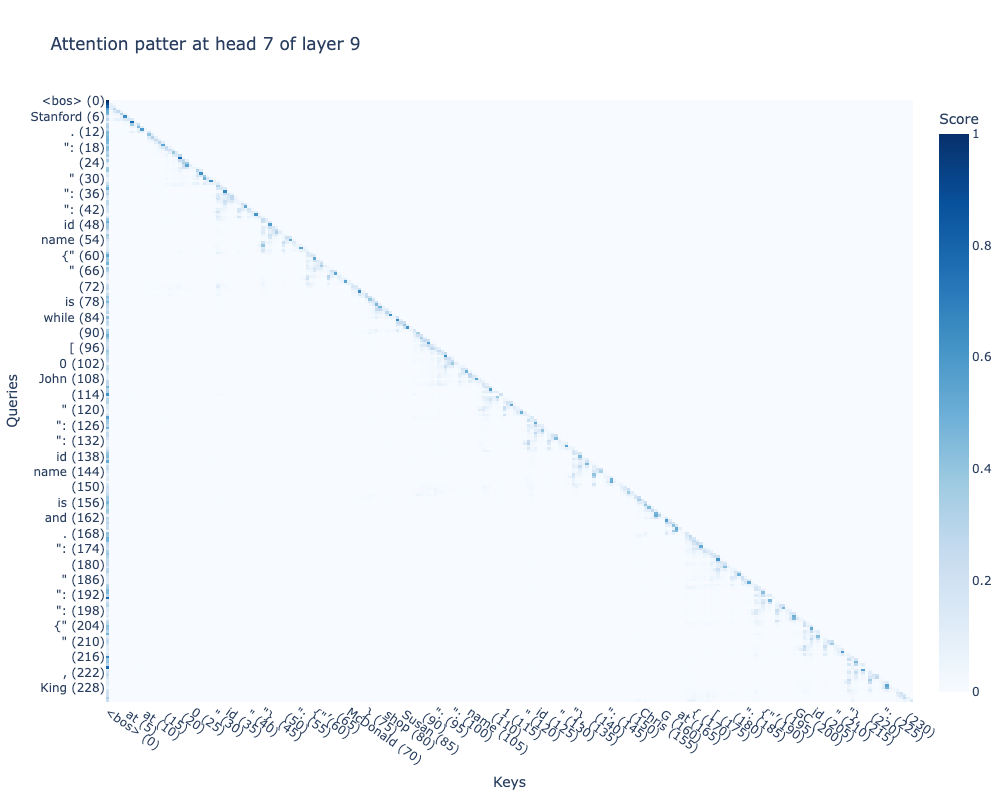

In [16]:
layer_id = 9
head_id = 7

with torch.no_grad():
    _, cache = model.run_with_cache(model.to_tokens(prompt))

data = cache[f'blocks.{layer_id}.attn.hook_pattern'][0, head_id].cpu()

labels = [f"{tok} ({i})" for i, tok in enumerate(model.to_str_tokens(prompt))]

# Create the plot using Plotly Express
fig = px.imshow(
    data,
    labels=dict(x="Keys", y="Queries", color="Attention Score"),
    x=labels,
    y=labels,
    title=f'Attention patter at head {head_id} of layer {layer_id}',
    color_continuous_scale="Blues",
    aspect='auto'
)

# Adjust the layout for better readability
fig.update_xaxes(tickangle=35)
fig.update_layout(coloraxis_colorbar=dict(title="Score"), height=800)

### Testing

In [75]:
print(model.generate(test_prompt, stop_at_eos=False, temperature=0, max_new_tokens=32))

  0%|          | 0/32 [00:00<?, ?it/s]

Paul Smith is a lawyer in Chicago. When Mr. Smith comes home, he usually cooks for his wife Lina. She's a teacher in a small school of The White City.
(Paul Smith | 0) is a lawyer in (Chicago | 1). When (Mr. Smith | 0) comes home, (he | 0) usually cooks for his wife (Lina | 2). (She | 2)'s a teacher in a small school of (The White City | 1).

The lion Roger has escaped his cage in a zoo in Paris. Panic is spreading in the capital as time passes and the king of the jungle has not yet been found.
The lion (Roger | 0) has escaped his cage in a zoo in (Paris | 1). Panic is spreading in the (capital | 1) as time passes and the (king of the jungle | 0) has not yet been found.

Yesterday I sold my car to John. It was a Ford and he liked it very much!


Yesterday I sold my car to John. It was a Ford and he liked it very much!

Yesterday I sold my car to John. It was a Ford


In [81]:
tokens = model.to_tokens(test_prompt)
max_new_tokens = 32

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, lam=lambdas[l - start_layer]),
                ) for l in range(start_layer, model.cfg.n_layers)
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 32/32 [00:03<00:00,  8.21it/s]

<bos>Paul Smith is a lawyer in Chicago. When Mr. Smith comes home, he usually cooks for his wife Lina. She's a teacher in a small school of The White City.
(Paul Smith | 0) is a lawyer in (Chicago | 1). When (Mr. Smith | 0) comes home, (he | 0) usually cooks for his wife (Lina | 2). (She | 2)'s a teacher in a small school of (The White City | 1).

The lion Roger has escaped his cage in a zoo in Paris. Panic is spreading in the capital as time passes and the king of the jungle has not yet been found.
The lion (Roger | 0) has escaped his cage in a zoo in (Paris | 1). Panic is spreading in the (capital | 1) as time passes and the (king of the jungle | 0) has not yet been found.

Yesterday I sold my car to John. It was a Ford and he liked it very much!


Yesterday I sold my car to John. It was a Ford and <em><b>it was</strong></i> (1) a Ford and <i><strong>it was a
